In [1]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

path = untar_data(URLs.CAMVID)
print(path.ls()) # prints subdirectories


Bad key "text.kerning_factor" on line 4 in
/home/ruslan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


[PosixPath('/home/ruslan/.fastai/data/camvid/codes.txt'), PosixPath('/home/ruslan/.fastai/data/camvid/images'), PosixPath('/home/ruslan/.fastai/data/camvid/labels'), PosixPath('/home/ruslan/.fastai/data/camvid/valid.txt')]


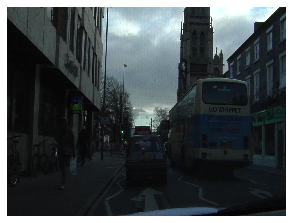

In [2]:
path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [3]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

print(get_y_fn(img_f))

/home/ruslan/.fastai/data/camvid/labels/0001TP_006810_P.png


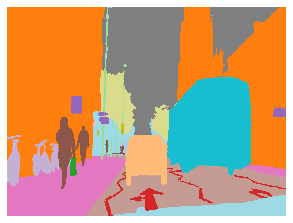

In [4]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [5]:
codes = ["Animal", "Archway", "Bicyclist", "Bridge", "Building", "Car", "CartLuggagePram", "Child",
         "Column_Pole", "Fence", "LaneMkgsDriv", "LaneMkgsNonDriv", "Misc_Text", "MotorcycleScooter",
         "OtherMoving", "ParkingBlock", "Pedestrian", "Road", "RoadShoulder", "Sidewalk", "SignSymbol",
         "Sky", "SUVPickupTruck", "TrafficCone", "TrafficLight", "Train", "Tree", "Truck_Bus",
         "Tunnel", "VegetationMisc", "Void", "Wall"]

In [6]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 8

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_fname_file('../valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

In [7]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/ruslan/.fastai/data/camvid/images;

Test: None

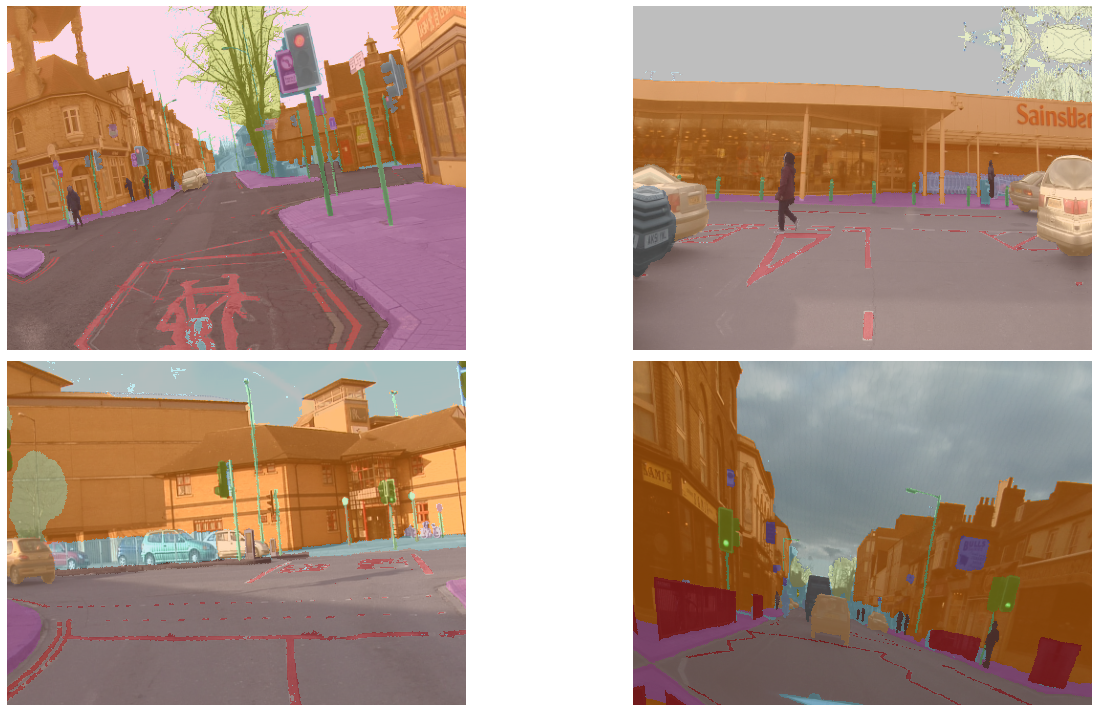

In [8]:
data.show_batch(rows=2, figsize=(20, 10))

In [8]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [8]:
# learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2).to_fp16()
learn = unet_learner(data, models.resnet34).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


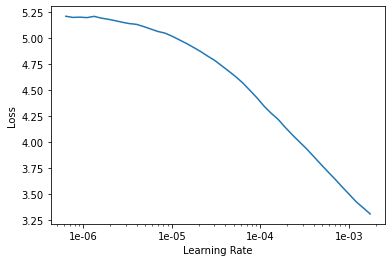

In [10]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [ ]:
lr = 3e-3 # pick a lr
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # train model

epoch,train_loss,valid_loss,acc_camvid,time
0,1.254194,0.834368,0.812003,00:37
1,0.866007,0.666464,0.831047,00:35


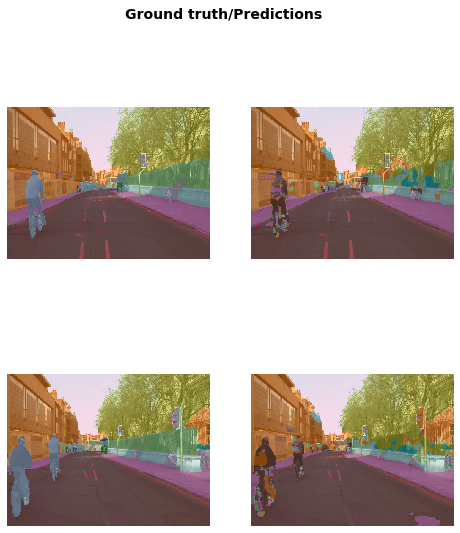

In [29]:
learn.save('camvid-stage-1') # save model
learn.show_results(rows=3, figsize=(8, 9)) # show results

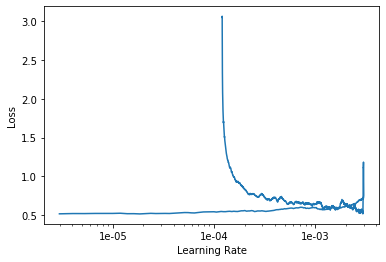

In [35]:
learn.unfreeze() # unfreeze all layers

# find and plot lr again
learn.recorder.plot()

In [36]:
# train model 
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.504035,0.422744,0.878670,00:52
1,0.484786,0.424473,0.879124,00:52
2,0.487215,0.416940,0.880382,00:52
3,0.484840,0.404456,0.890681,00:52
4,0.467012,0.416349,0.882713,00:52
5,0.452218,0.383814,0.892716,00:52
6,0.436085,0.390024,0.888914,00:52
7,0.448989,0.379508,0.891409,00:52
8,0.432372,0.387429,0.892532,00:52
9,0.467659,0.375274,0.894392,00:52


In [41]:
learn.save('camvid-stage-2')

## Test the model

In [9]:
learn.load('camvid-stage-2');

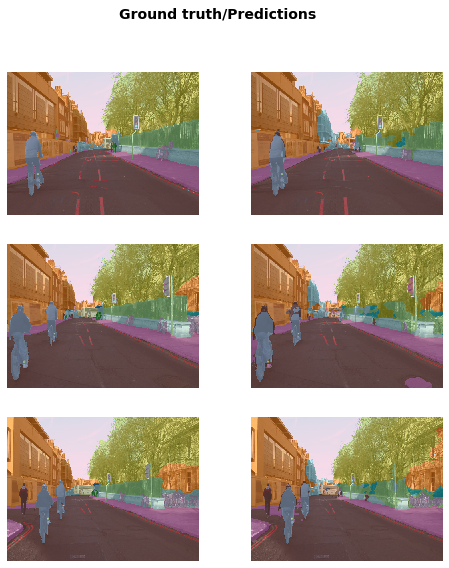

In [11]:
learn.show_results(rows=3, figsize=(8, 9)) # show results

In [12]:
from sklearn.metrics import confusion_matrix  
import numpy as np

def compute_iou(y_pred, y_true, labels=[0,1,2]):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=labels)
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoUs = (intersection + 1e-8) / ( union.astype(np.float32) + 1e-8 )

    return IoUs

In [38]:
from tqdm import tqdm
Y = src.valid.y
X = src.valid.x

IoUs = []
for x_valid, y_true in zip(tqdm(X), Y):
    y_pred = learn.predict(x_valid)
    
    y = np.array(y_true.data[0])
    y.resize(size)
    y_hat = np.array(y_pred[1][0])
    
    labels_ious = compute_iou(y, y_hat, labels=np.arange(len(codes)))
    mean_img_iou = np.mean(labels_ious)
    IoUs.append(mean_img_iou)
    


100%|██████████| 101/101 [00:13<00:00,  7.44it/s]

Mean IoU for entire validation dataset: 0.4182900407956356


In [41]:
print('Mean IoU for entire validation dataset: {} for {} classes'.format(np.mean(IoUs), len(codes)))

Mean IoU for entire validation dataset: 0.4182900407956356 for 32 classes


Inference took 1.0968 [sec]
Output image shape: torch.Size([3, 360, 480])


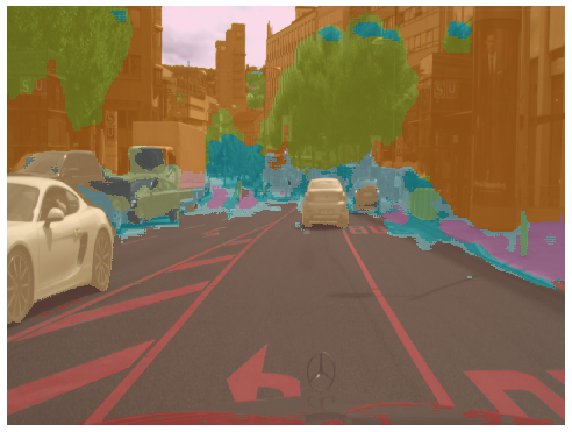

In [10]:
test_img = open_image('/home/ruslan/Desktop/example_images/example_04.png')

import time
start = time.time()
output = learn.predict( test_img )
print('Inference took %.4f [sec]'%(time.time()-start))

test_resized = test_img.apply_tfms(None, size=output[0].shape)
print('Output image shape:', test_resized.shape)

test_resized.show(figsize=(10,10), y=learn.predict(test_resized)[0])

### Video Inference

In [21]:
import imutils
import cv2
from tqdm import tqdm

def np_img2fastai_img(np_img):
    img_fastai = Image(pil2tensor(np_img, dtype=np.float32).div_(255))
    return img_fastai

vs = cv2.VideoCapture('../data/videos/moscow_streets.mp4')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

# COLORS = open("unet-colors.txt").read().strip().split("\n")
# COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
# COLORS = np.array(COLORS, dtype="uint8")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(codes) - 1, 3), dtype="uint8")
COLORS = np.vstack([COLORS, [0, 0, 0]]).astype("uint8")

FPS = []
# while(1):
for i in tqdm( range(100) ):
    # get raw frames from video stream
    ret, frame = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame_fastai = np_img2fastai_img(frame)
    output = learn.predict( frame_fastai )
    end = time.time()
    FPS.append(1./(end-start))
#     print("[INFO] single frame took {:.4f} seconds".format(end-start))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('../data/videos/moscow_fastai_camvid.avi', fourcc, 30,
            (size[1], size[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # preprocess output frames before writing to disk
    classMap = np.array(output[1][0], dtype=np.uint8)
    mask = COLORS[classMap]
    frame_resized = cv2.resize(frame, (size[1], size[0]), interpolation = cv2.INTER_AREA)
    output_to_write = (0.3 * frame_resized + 0.7 * mask).astype("uint8")
    # write the output frame to disk
#     writer.write(output_to_write)
print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS[1:])))


  2%|▏         | 2/100 [00:00<00:05, 17.14it/s]

[INFO] 12911 total frames in video
[INFO] single frame took 0.0603 seconds
[INFO] estimated total time: 12.9813 [min]


100%|██████████| 100/100 [00:04<00:00, 21.29it/s]

[INFO] Mean FPS 23.9881 Hz
